<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/8_Linear_unsupervised_learning/8_3_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Chapter 8: Linear Unsupervised Learning

# 8.3  The Linear Autoencoder and Principal Component Analysis

The most fundamental unsupervised learning method, known as Principal Com- ponent Analysis or PCA for short, follows directly from our discussion in the previous section regarding fixed spanning set representations with one crucial caveat: instead of just learning the proper weights to best represent input data over a given fixed spanning set we learn a proper spanning set as well.

In [ ]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_8_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_datasets
    else:
        print('chapter_8_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_8_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_library
    else:
        print('chapter_8_library already cloned!')

    # clone images
    if not Path('chapter_8_images').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_images
    else:
        print('chapter_8_images already cloned!')

    # clone videos
    if not Path('chapter_8_videos').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_videos
    else:
        print('chapter_8_videos already cloned!')

## run universally whether in collab or local ##
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_8_library') 
sys.path.append('./chapter_8_images') 
sys.path.append('./chapter_8_datasets') 

# import section helper
import section_8_3_helpers

# dataset paths
dataset_path_1 = 'chapter_8_datasets/2d_span_data.csv'
dataset_path_2 = 'chapter_8_datasets/3d_span_data.csv'

# image paths
image_path_1 = "chapter_8_images/pca_classic.png"
image_path_2 = "chapter_8_images/Fig_9_7.png"

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image
import autograd.numpy as np
from matplotlib import gridspec

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 8.3.1  Learning proper spanning sets

Imagine we return to the previous Section where we discussed how - given a fixed basis or spanning set of $K \leq N$ vectors $\mathbf{c}_1,\,\mathbf{c}_2,...,\mathbf{c}_K$ - we can represent a set of $P$ mean-centered points $\mathbf{x}_1,\,\mathbf{x}_2,...,\mathbf{x}_P$ as

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

tuning the weights $w_{p,n}$ by minimizing a Least Squares cost function

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

In general when we used a full set of *linearly independent* $K = N$ fixed basis vectors we can learn corresponding weights that drive this cost function to zero, and give us strict equality in equation (1).

In the previous Section we supposed that our spanning set / basis $\mathbf{C}$ was *fixed*.  However here we will *learn* a proper basis (along with the weights).  This slight thematic twist - where we *learn* the basis along with the proper weights - is called *Principal Component Analysis*.

How can we *learn* a proper basis for a given dataset?  Well, we can imagine that with an ideal basis $\mathbf{C}$ and properly tuned our weight vectors / encodings $\mathbf{w}_p$ we could drive the value of the Least Squares error above even lower than we could with any fixed basis (since at least in principle we should be able to learn a basis that provides just as small of an error as any fixed one).  In other words, to learn a quality basis $\mathbf{C}$ we should be *minimizing* the cost function above over $\mathbf{C}$ as well as the weight vectors / encodings $\mathbf{w}_1,\,...,\mathbf{w}_P$.

Adding $\mathbf{C}$ to the list of optimization variables we need to minimize with respect to, this Least Squares cost function takes the similar form 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

Again - the only thing that has changed here is that now (since we aim to learn the basis $\mathbf{C}$ as well, it has been added to the list of variables we wish to minimize the original Least Squares cost function with respect to.   

This cost function can be properly minimized using any number of standard approaches like e.g., gradient descent or coordinate / block-coordinate descent.  Below we look at a few simple examples where we use gradient descent to minimize the cost, determining proper bases and weight vectors.

#### <span style="color:#a50e3e;">Example 1: </span> Learning a complete basis via gradient descent

In this first example we will use gradient descent to determine a *complete* basis for the two dimensional data shown below.  We will also center the data below by subtracting off the mean of each input dimension.

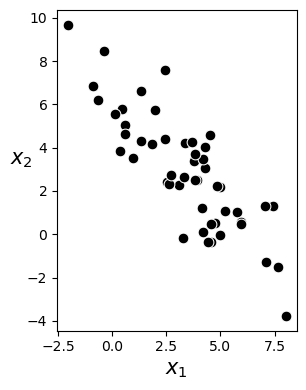

In [ ]:
# import data
X_original = np.loadtxt(dataset_path_1,delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# scatter dataset
fig = plt.figure(figsize = (9,4))
gs = gridspec.GridSpec(1,1) 
ax = plt.subplot(gs[0],aspect = 'equal'); 
ax.set_xlabel(r'$x_1$',fontsize = 15);ax.set_ylabel(r'$x_2$',fontsize = 15,rotation = 0);
ax.scatter(X_original[0,:],X_original[1,:],c = 'k',s = 60,linewidth = 0.75,edgecolor = 'w');

Now we can implement the least squares cost function in equation (4).  To stay consistent with our style for implementing cost functions, we will input package the weights for $\mathbf{C}$ and $\mathbf{W}$ in a single input list `w` as `w = [C,W]`.  Once inside the cost function we can then simply strip off each matrix of weights and compute the cost function, as shown below in the implementation.

In [ ]:
# an implementation of the least squares cost function for PCA
# here the weight matrices are loaded in a single list w = [C,W]
def least_squares(w):  
    # strip off C and W parameters
    C = w[0]
    W = w[1]
    
    # compute the least squares cost
    cost = np.sum((np.dot(C,W) - X)**2)
    return cost/float(X.shape[1])

Now make a run of $100$ gradient descent steps with a fixed steplength parameter $\alpha = 1$ for all steps in order to minimize the PCA Least Squares cost function implemented above.  Here we use the implementation of gradient descent given in [Section 3.6](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_6_Descent.html), which we employ via a backend file.

With our gradient descent run complete we can plot the associated cost function history to make sure the method has converged sufficiently for our settings.  We do this below.

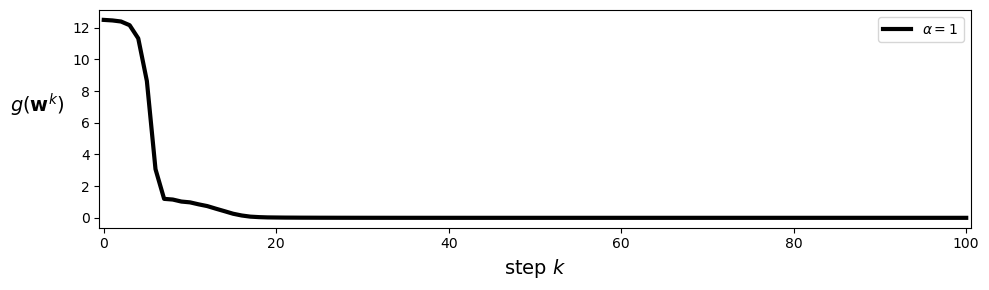

In [ ]:
# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);

# initialize both matrices of parameters
num_elements = 2; scale = 0.1;
C = scale*np.random.randn(X.shape[0],num_elements)
W = scale*np.random.randn(num_elements,X.shape[1])
w = [C,W]

# run gradient descent
weight_history,cost_history = section_8_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

# plot the cost function history for a given run
section_8_3_helpers.plot_cost_histories([cost_history],start = 0,points = False,labels = [r'$\alpha = 1$'])

In the left panel below we plot our best recovered basis (from the final step of the run above) along with the original data.  Here the two basis vectors - shown as red arrows - are essentially two random vectors in the plane.  Essentially any two random vectors will do here since they will span the entire space of the data, giving a perfect representation.  In the right panel we plot the encoded version of the data - i.e., the associated learned weight vectors $\mathbf{w}_p$ (see the previous Section if this nomenclature is unfamiliar).

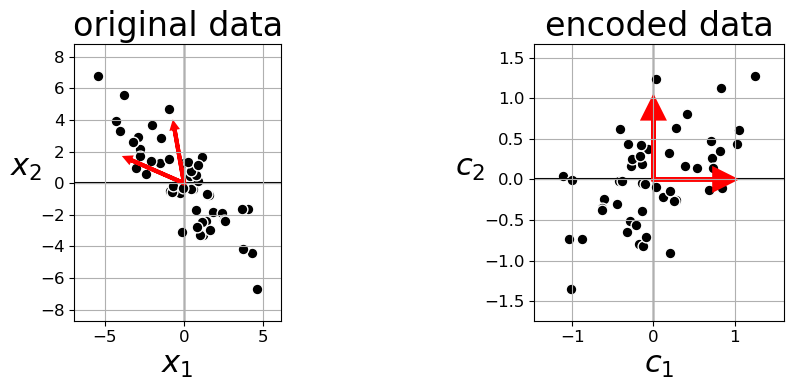

In [ ]:
# plot the original data with determined basis, and the encoded version
# of the data (i.e., the associated weight vectors)
C = weight_history[-1][0]
section_8_3_helpers.perfect_visualize_transform_static(C,X=X)

To empirically validate (at least to some degree) the notion that proper minimization will - in this instance - recover essentially any two random vectors, we show the results of three more runs of gradient descent using the same parameters as above but with a random initialization in each instance.  We plot the best recovered basis in each instance afterwards, and as we can see each instance differs considerably from the others (recovering two linearly independent vectors in each case).

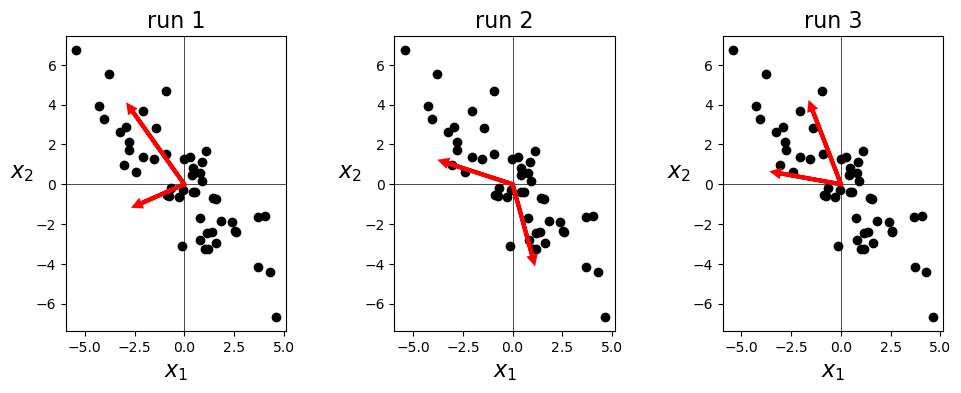

In [ ]:
# make three runs of gradient descent to minimie the autoencoder, and plot the resulting
# principal components found
best_bases = []
num_runs = 3
max_its = 100; alpha_choice = 10**(0);
num_elements = 2; scale = 0.1; g = least_squares;
for i in range(num_runs):
    # generate random initial matrices
    C = scale*np.random.randn(X.shape[0],num_elements)
    W = scale*np.random.randn(num_elements,X.shape[1])
    w = [C,W]

    # run gradient descent to minimize the PCA least squares cost
    weight_history,cost_history = section_8_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

    # pluck out best weights
    ind = np.argmin(cost_history)
    C_best = weight_history[ind][0]
    best_bases.append(C_best)
    
# plot all three autoencoder solutions
section_8_3_helpers.visual_comparison(X,best_bases)

#### <span style="color:#a50e3e;">Example 2: </span> Learning a proper subspace via gradient descent

In this example we use gradient descent to minimize the PCA Least Squares cost in order to learn the best two-dimensional subspace representation of an $N=3$ dimensional dataset consisting of $100$ points.   We load in the dataset below and mean-center it.

Now we make a run of $100$ gradient descent steps with a fixed steplength value of $\alpha = 1$ for each step.  With these settings gradient descent converges very well.  Notice: to learn $2$ basis elements we initialize $\mathbf{C}$ as a random $3 \times 2 $ matrix (i.e., it will have only two spanning vectors), and likewise initialize each weight vector to have only two entries.

In [ ]:
# load in dataset
X_original = np.loadtxt(dataset_path_2,delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# run gradient descent to minimize the Least Squares cost for linear regression
g = least_squares; max_its = 100; alpha_choice = 10**(0);

# set up initialization
scale = 0.1;
C = scale*np.random.randn(3,2)
W = scale*np.random.randn(2,100)
w = [C,W]

# run gradient descent
weight_history,cost_history = section_8_3_helpers.gradient_descent(g,alpha_choice,max_its,w)

With this run complete we can plot our two learned spanning vectors $\mathbf{c}_1$ and $\mathbf{c}_2$, the two-dimensional subspace it spans, etc.,  We do this below.  The left panel shows the original data (as gray dots), learned spanning vectors (shown as red arrows), and corresponding subspace colored in light red.  This is the very best two-dimensional subspace representation for the input data.  In the middle panel we show the corresponding learned weight vectors / encodings $\mathbf{w}_p$ of the original input $\mathbf{x}_p$ in the space spanned by the recovered spanning vectors.  In the right panel we show the original data space again and the decoded data points (gray dots with red borders) - i.e., the projection of each datapoint onto the space spanned by our learned basis.  As detailed in the previous Section the decoded version of the $p^{th}$ point $\mathbf{x}_p$ is computed as $\mathbf{C}\mathbf{w}_p$, where $\mathbf{C}$ and $\mathbf{w}_p$ are the fully learned basis and encoding for the $p^{th}$ point. 

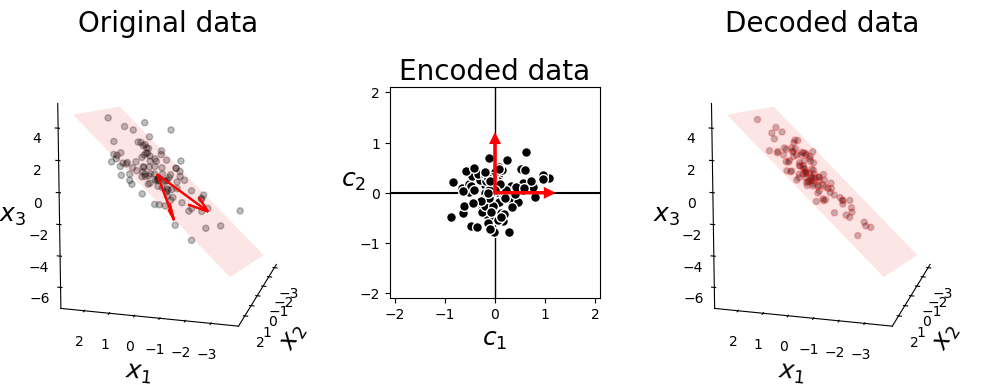

In [ ]:
# produce visuals
C = weight_history[-1][0]
view = [15,105]
section_8_3_helpers.project_data_from_3d_to_2d(X,C,view)

## 8.3.2 The Linear Autoencoder

As detailed in the previous Section, if our $K$ spanning vectors concatenated column-wise to form the spanning matrix $\mathbf{C}$ are orthonormal, then the encoding of each $\mathbf{x}_p$ may be written simply as $\mathbf{w}_p = \mathbf{C}^T \mathbf{x}_p$. If we plug in this simple solution for $\mathbf{w}_p$ into the $p$th summand of the Least Squares cost above, we get a cost that is a function of \(\mathbf{C}\) 

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\label{equation:linear-autoencoder}
\end{equation}

We can think of this Least Squares as enforcing the \emph{Autoencoder} formulae shown in the prior Section to hold when properly minimized, and thus it is often referred to as the \emph{linear Autoencoder}.  Instead of being given an encoding/decoding scheme for each data point, by minimizing this cost function we \emph{learn} one.

Even though we were led to the linear Autoencoder by assuming our spanning matrix $\mathbf{C}$ is orthonormal, we need not constrain our minimization of Equation (\ref{equation:linear-autoencoder}) to enforce this condition because, as is shown in the textbook appendix of this Chapter, the minima of the linear Autoencoder are \emph{always} orthonormal.

## 8.3.3  Principal Component Analysis

The linear Autoencoder cost may have many minimizers, of which the set of principal components is a particularly important one. The spanning set of principal components always provide a consistent skeleton for a dataset, with its members pointing in the dataset’s *largest directions of orthogonal variance*. Employing this particular solution to the linear Autoencoder is often referred to as Principal Component Analysis, or PCA for short, in practice.

This idea is illustrated for a prototypical $N = 2$ dimensional dataset in Figure 8.6, where the general elliptical distribution of the data is shown in light grey. A scaled version of the first principal component of this dataset (shown as the longer red arrow) points in the direction in which the dataset is most spread out, also called its largest direction of variance. A scaled version of the second principal component (shown as the shorter of the two red arrows) points in the next most important direction in which the dataset is spread out that is orthogonal to the first.

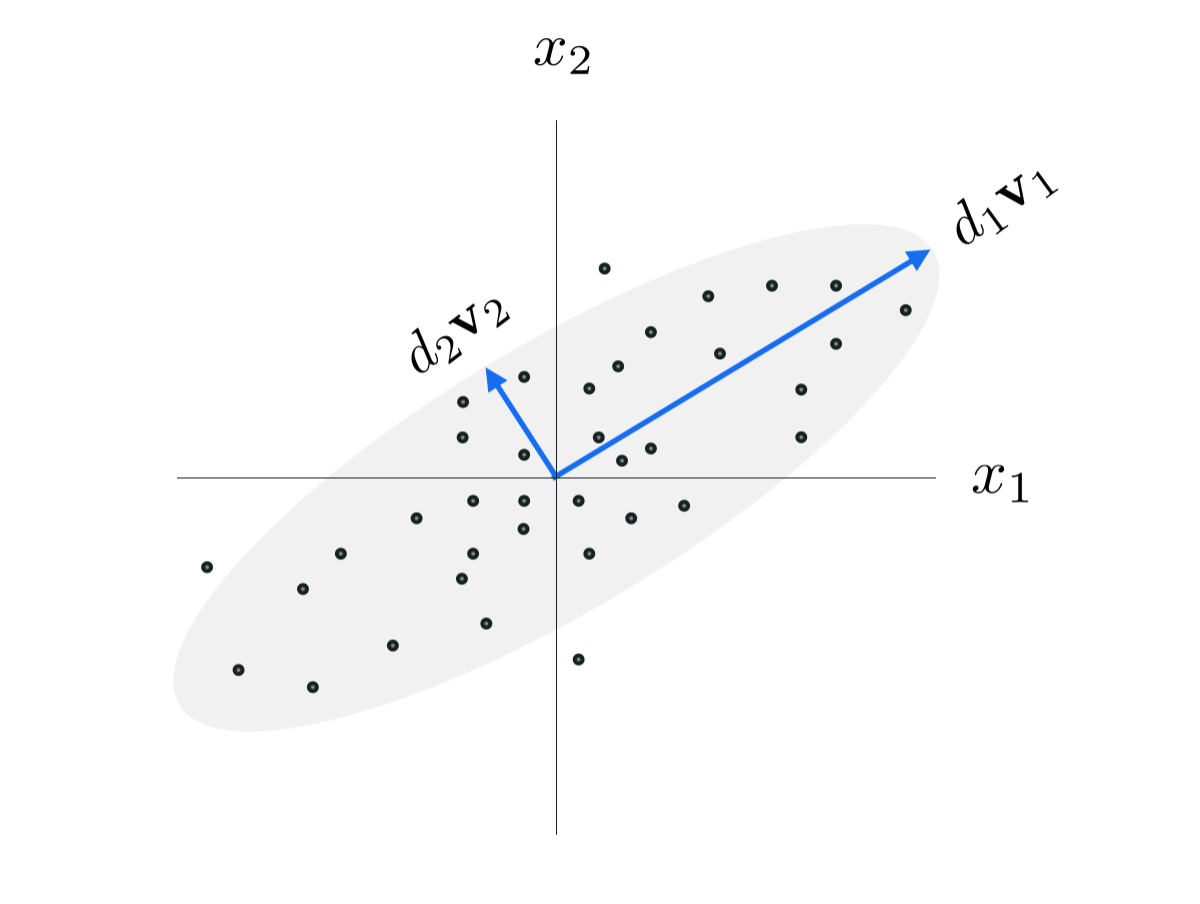

In [ ]:
Image(image_path_1)

<figure>
  <figcaption>   
<strong>Figure 1:</strong> <em> The classic orthogonal PCA minimizer of the autoencoder cost function.  The elements of this basis point in the orthogonal directions of variance of the dataset, that is the orthogonal directions in which the dataset is most spread out.  Here we show a prototypical two-dimensional example where the recovered bases elements $\mathbf{c}_1 = d_1\mathbf{v}_1$ and $\mathbf{c}_2 = d_2\mathbf{v}_2$ are - as we will see below - constructed from the eigenvalues / vectors of the data covariance matrix.
</em>  </figcaption> 
</figure>

As we show in subsection following this one, this special orthonormal minimizer of the linear Autoencoder is given by the eigenvectors of the so-called covariance matrix of the data.

Denoting by $X$ the $N \times P$ data matrix consisting of our $P$ mean-centered input points stacked column-wise

\begin{equation}
\mathbf{X} = 
\begin{bmatrix}
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert \\
\,\, \mathbf{x}_1 \,\,\, \mathbf{x}_2 \,\,\, \cdots \,\,\, \mathbf{x}_P \\
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert 
\end{bmatrix}
\end{equation}

the orthogonal basis provided by this special solution (called the *Principal Components* of a dataset) can be computed (as a minimum of the Autoencoder cost function) as the *eigenvectors* of the corresponding *correlation matrix* of this data

\begin{equation}
\text{covariance matrix of } \, \mathbf{X}: = \, \frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T
\end{equation}

Denoting the eigenvector/value decomposition of the covariance matrix 
$\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T$ is given as

\begin{equation}
\frac{1}{P}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

then above the orthonormal basis we recover is given precisely by the eigenvectors above, i.e., $\mathbf{C} = \mathbf{V}$.  Again, these are referred to in the jargon of machine learning as the *principal components* of the data.  Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

#### <span style="color:#a50e3e;">Example 1: </span>  Principal Components

In the left panel below we show the mean-centered data first displayed in the prior example, along with its two principal components (pointing in the two orthogonal directions of greatest variance in the dataset) shown as red arrows. In the right panel we show the encoded version of the data in a space where the principal components are in line with the coordinate axes.

In [ ]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    and division by its standard deviation
    
    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)
    return D,V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.  
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

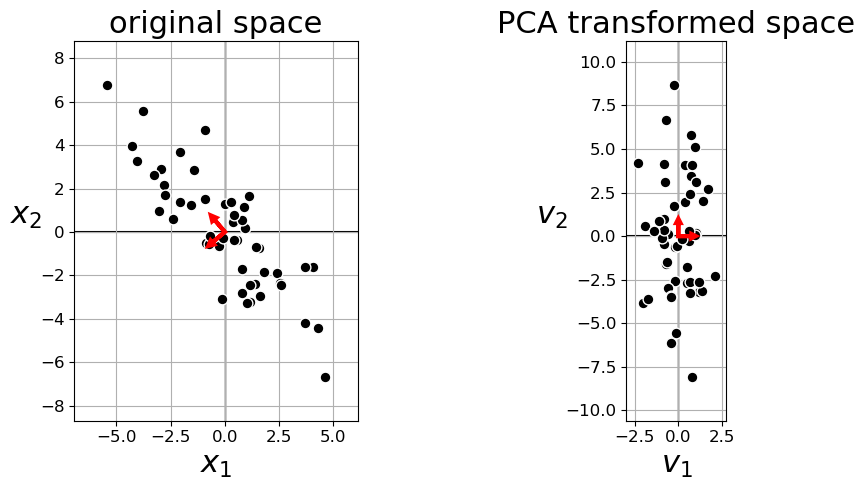

In [ ]:
# load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(dataset_path_1,delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,V = pca_transform_data(X)

# plot data in original and pca-transformed spaces
section_8_3_helpers.pca_visualizer(X,W,V)

#### <span style="color:#a50e3e;">Example 1: </span>  Principal Components

While PCA can technically be used to reduce the dimension of data in a predictive modeling scenario (in hopes of improving accuracy, computation time, etc.) it can cause severe problems in the case of classification. In the figure below we illustrate feature space dimension reduction via PCA on a simulated two-class dataset where the two classes are linearly separable. Because the ideal one-dimensional subspace for the data in this instance runs (almost) parallel to the ideal linear classifier, projecting the complete dataset onto this subspace completely destroys the inter-class separation. For this very reason, while it is commonplace to sphere classification data using PCA, as detailed in Section 9.5, one needs to be extremely careful using PCA as a dimension reduction tool with classification or when the data does not natively live in or near a linear subspace.

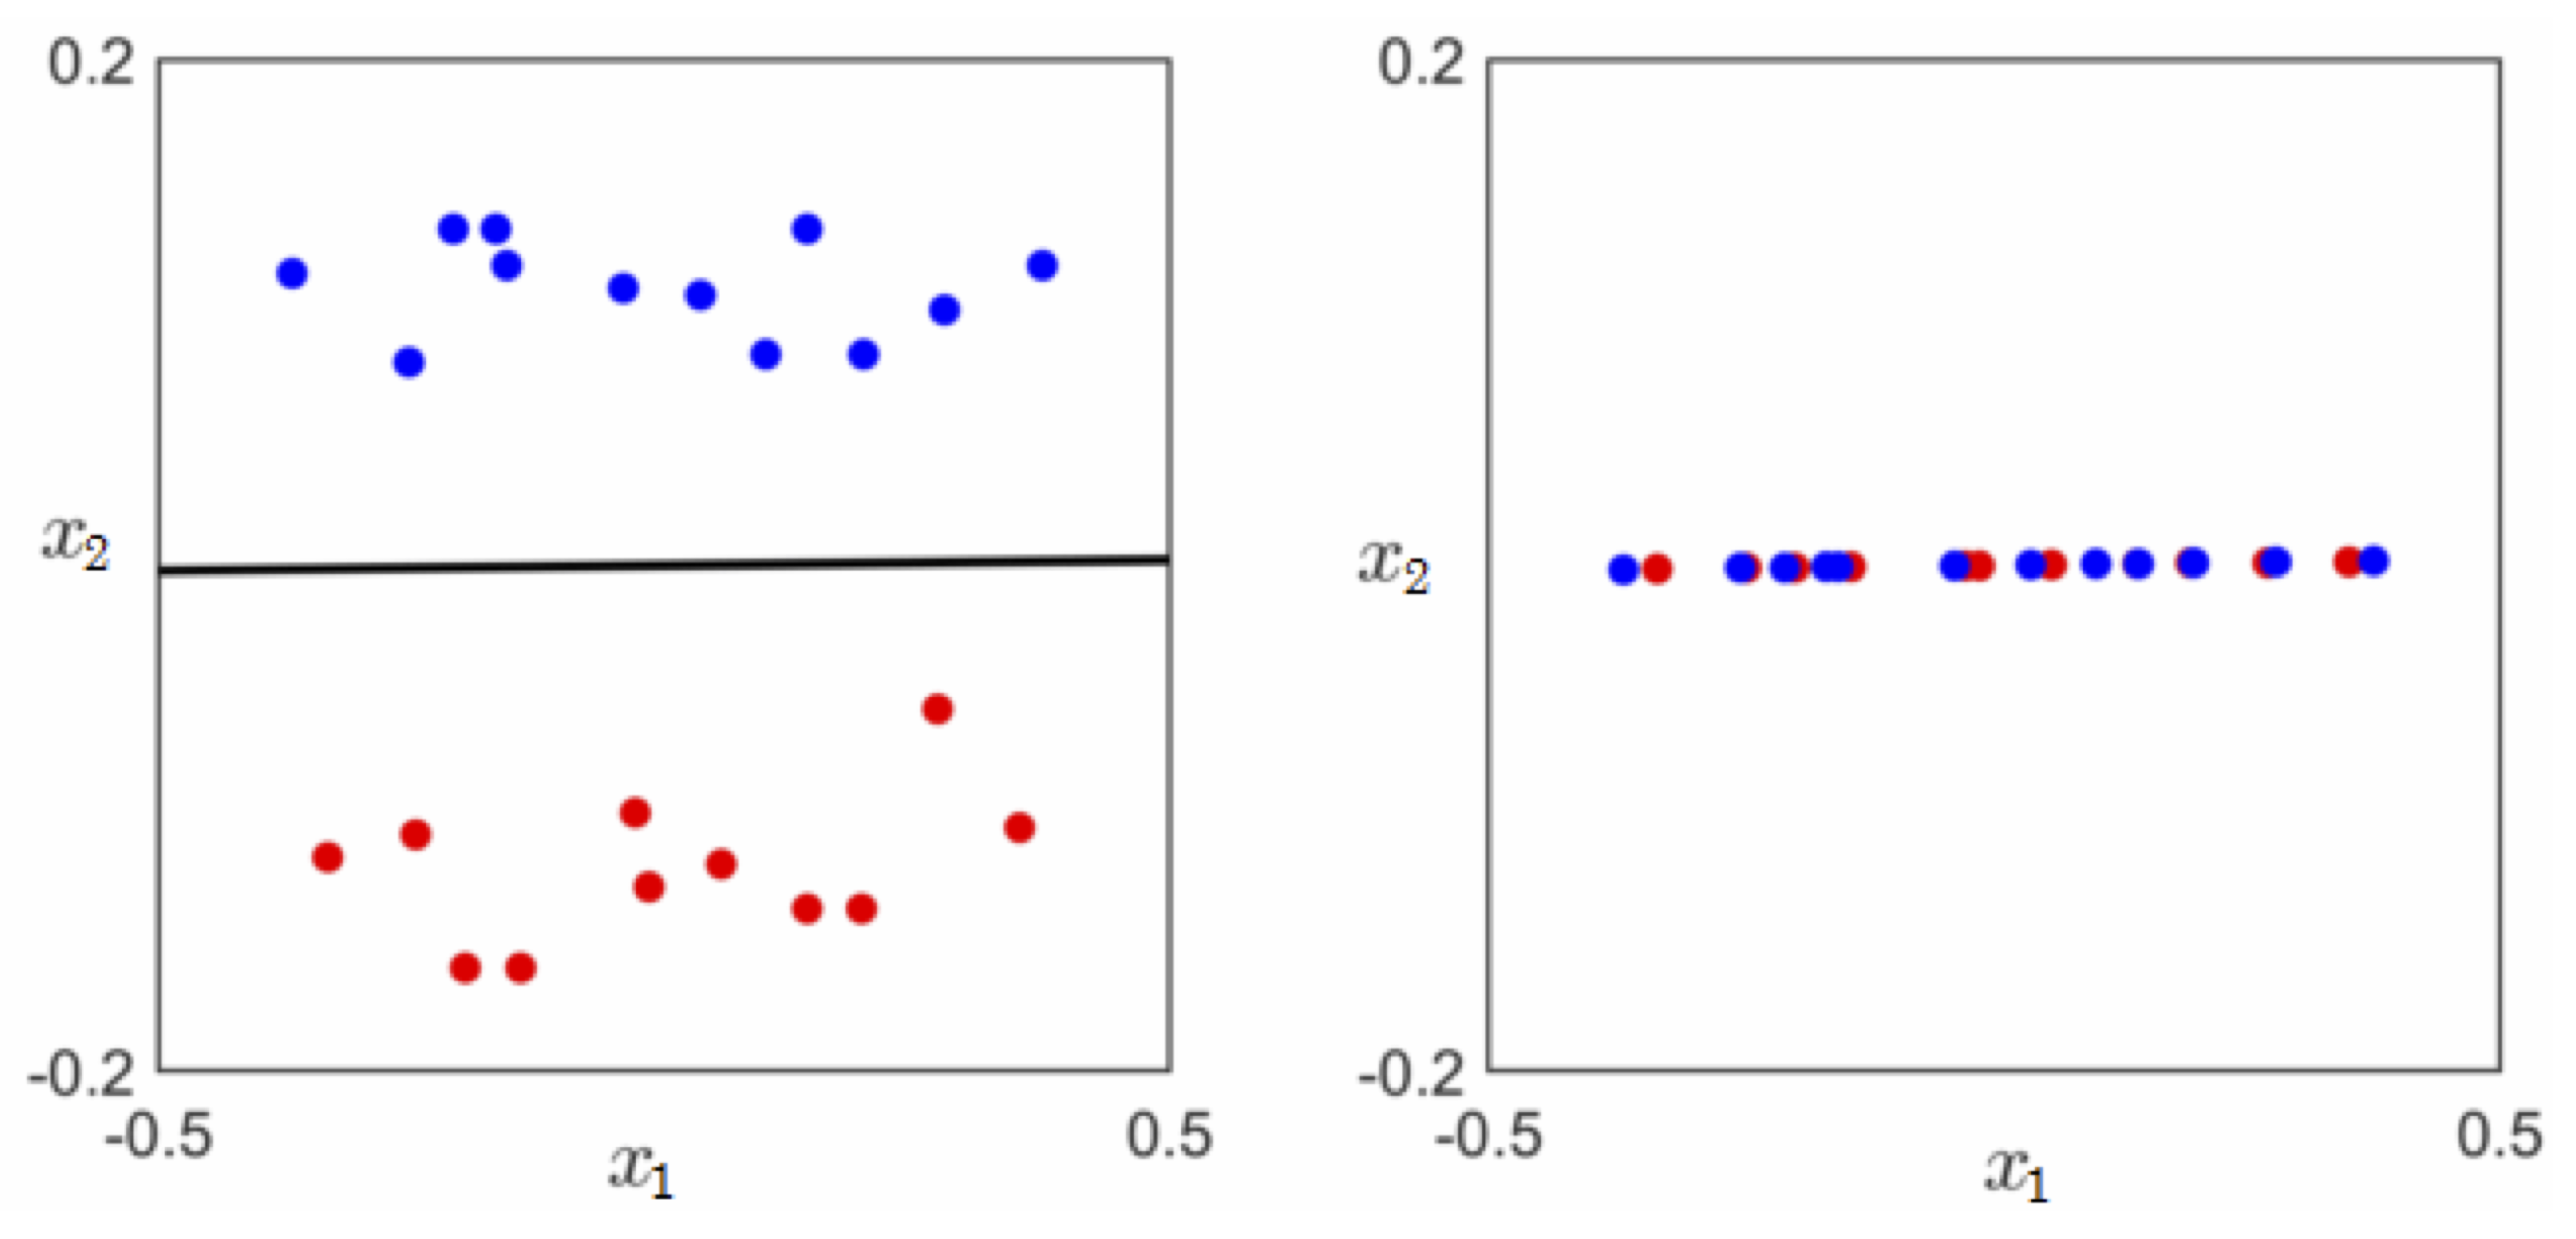

In [ ]:
Image(image_path_2)

<figure>
  <figcaption>   
<strong>Figure 3:</strong> <em> (left) A toy classification dataset consisting of two linearly separable classes. The ideal subspace produced via PCA is shown in black. (right) Projecting the data onto this subspace (in other words reducing the feature space dimension via PCA) destroys completely the original separability of the data.  </em>  </figcaption> 
</figure>

## 8.3.4  Formal derivation of the classic PCA solution to the autoencoder

From the previous Section we know that the minimizers of the Autoencoder cost function are all orthogonal.  Therefore the classic (orthogonal) PCA solution we compute below is indeed a global minimizer of the autoencoder.

To begin the derivation of the classic *Principal Components* solution to the Autoencoder all we must do is examine one summand of the Autoencoder cost function, under the assumption that $\mathbf{C}$ is orthogonal.  Expanding the of the $p^{th}$ summand we have

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  =  \mathbf{x}_p^T \mathbf{C}^T \mathbf{C}\mathbf{C} \mathbf{C}^T \mathbf{x}_p   -2\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p
\end{equation}

and then using our assumption that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{N\times N}$ we can see that it may be re-written equivalently as

\begin{equation}
 = -\mathbf{x}_p^T \mathbf{C}\mathbf{C}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p = -\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 + \left \Vert\mathbf{x}_p\right \Vert_2^2.
\end{equation}

Since our aim is to *minimize* the summation of terms taking the form of the above, and the data point $\mathbf{x}_p$ is fixed and does not include the variable $\mathbf{C}$ we are minimizing with respect to, minimizing the original summand on the left is equivalent to minimizing *only the first term* $-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2$ on the right hand side.  Summing up these terms, the $p^{th}$ of which can be written decomposed over each individual basis element we aim to learn as

\begin{equation}
-\left\Vert \mathbf{C}^T\mathbf{x}_p \right\Vert_2^2 = -\sum_{n=1}^N \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2,
\end{equation}

gives us the following cost function (that is equivalent to the autoencoder under our assumption of orthogonality) to minimize for our ideal orthogonal basis

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{p=1}^P \sum_{n=1}^K  \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Studying this reduced form of our Autoencoder cost function we can see that it *decomposes completely over the basis vectors $\mathbf{c}_n$*, i.e., there are no terms where $\mathbf{c}_i$ and $\mathbf{c}_j$ interact when $i\neq j$.  This means - practically speaking - that we can optimize our orthogonal basis *one element at a time*.  Reversing the order of the summands above we can isolate each individual basis element over the entire dataset, writing above equivalently as 

\begin{equation}
g\left(\mathbf{C}\right) = -\frac{1}{P}\sum_{n=1}^K \sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Now we can think about minimizing our cost function one basis element at a time.  Beginning with $\mathbf{c}_1$ we first isolate only those relevant terms above, which consists of: $-\frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,}\right)^2$.    Since there is a minus sign out front of this summation, this is the same as *maximizing* its negation which we denote as

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_1^T\mathbf{x}_p^{\,} \right)^2.
\end{equation}

Since our basis is constrained to be orthogonal the basis element $\mathbf{c}_1$ in particular is constrained to have unit-length.  Statistically speaking, the above measures the *sample variance of the dataset in the direction defined by $\mathbf{c}_1$*.  Note: this quantity is precisely the sample variance because our data is assumed to have been *mean-centered*.  Since we aim to maximize this quantity we can phrase our optimization in purely sample statistical terms as well: we aim to recover the a form of the basis vector $\mathbf{c}_1$ that points in the maximum direction of variance in the dataset.  

To determine the maximum value of the function above / determine the direction of maximum sample variance in the data we can rewrite the formula above by stacking the data points $\mathbf{x}_p$ column-wise - forming the $N\times P$ matrix $\mathbf{X}$ - giving the equivalent formula in 

\begin{equation}
h\left(\mathbf{c}_1\right) = \frac{1}{P}\mathbf{c}_1^T \mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \mathbf{c}_1^{\,} = \mathbf{c}_1^T\left(\frac{1}{P}\mathbf{X}^{\,}_{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_1^{\,}.
\end{equation}

Written in this form the above takes the form of a so-called *Rayleigh Quotient*  whose maximum can is expressible algebraically in closed form based on the eigenvalue / eigenvector decomposition of the matrix $\mathbf{X}^{\,}\mathbf{X}^T$ (in the middle term) or likewise the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ (in the term on the right).  Because the matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ can be interpreted statistically as the *covariance matrix* of the data it is more common to use the particular algebraic arrangement on the right.

So, denoting denoting $\mathbf{v}_1$ and $d_1$ the eigenvector and largest eigenvalue of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ the maximum of the above occurs when $\mathbf{c}_1 = \mathbf{v}_1$, where $h\left(\mathbf{v}_1\right) = d_1$ - which is also the variance in this direction.  Remember: this direction $\mathbf{v}_1$ points in the largest direction of variance in the dataset.  In the jargon of machine learning $\mathbf{v}_1$ is referred to as the *first Principal Component* of the data, hence the name *Principal Component Analysis*.

With our first basis vector in hand, we can move on to determine the second element of our ideal orthogonal spanning set.  Plucking out the relevant terms from equation (37) and following the same thought process we went through above results in the familiar looking function

\begin{equation}
h\left(\mathbf{c}_2\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_2^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

that we aim to maximize in order to recover our second basis vector.  This formula has the same sort of statistical interpretation as the analogous version of the first basis vector had above - here again it calculates the variance of the data in the direction of $\mathbf{c}_2$.  Since our aim here is to maximize - given that $\mathbf{c}_1$ has already been resolved and that $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$ due to our orthogonal assumption - the statistical interpretation here is that we are aiming to find the *second* largest orthogonal direction of sample variance in the data.

This formula can also be written in compact vector-matrix form as $h\left(\mathbf{c}_2\right) = \mathbf{c}_2^T \left(\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T_{\,} \right)\mathbf{c}_2^{\,}$, and its maximum (given our restriction to an orthogonal basis implies that we must have $\mathbf{c}_1^T\mathbf{c}_2^{\,} = 0$) is again expressible in closed form in terms of the eigenvalue / eigenvector decomposition of the covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$.  Here the same analysis leading to the proper form of $\mathbf{c}_1$ shows that the the maximum of the above occurs when $\mathbf{c}_2 = \mathbf{v}_2$ the eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its second largest eigenvalue $d_2$, and the variance in this direction is then $h\left(\mathbf{v}_2\right) = d_2$.  This ideal basis element / direction is referred to as the *second principal component of the data*.

More generally - following the same analysis for the $n^{th}$ member of our ideal orthonormal basis we look to maximize the familiar looking formula

\begin{equation}
h\left(\mathbf{c}_n\right) = \frac{1}{P}\sum_{p=1}^P \left(\mathbf{c}_n^T\mathbf{x}_p^{\,} \right)^2
\end{equation}

As with the first two cases above, the desire to maximize this quantity can be interpreted as the quest to uncover the $n^{th}$ orthogonal direction of sample variance in the data.  And following the same arguments, writing the above more compactly as $h\left(\mathbf{c}_n\right) = \mathbf{c}_n^T\left(\frac{1}{P} \mathbf{X}^{\,}\mathbf{X}^T_{\,}\right)\mathbf{c}_n^{\,}$ etc.,, we can show that it takes the form $\mathbf{c}_n = \mathbf{v}_n$, where $\mathbf{v}_n$ is the $n^{th}$ eigenvector of $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T$ associated with its $n^{th}$ largest eigenvalue $d_n$, and here the sample variance is expressible in terms of this eigenvalue $h\left(\mathbf{c}_n\right) = d_n$.  This is learned element / direction is referred to as the $n^{th}$ principal component of the data.